# RQ8 — Joint Semantic–Geometric Calibration for Reliability

**Research Question**: How can semantic confidence and localization quality be jointly calibrated to yield meaningful scores for ranking/selection?

**Hipótesis**: Los scores semánticos crudos están desalineados con la calidad geométrica (IoU); una calibración conjunta restaura la monotonicidad y mejora métricas de ranking (e.g., Precision@K) incluso cuando el mAP cambia poco.

**Expected Results**:
- **Figure RQ8.1**: Confiabilidad de los scores de detección respecto a la calidad geométrica (mean IoU por bin de confianza). La calibración conjunta mejora sustancialmente la alineación monotónica entre score y precisión de localización.
- **Figure RQ8.2**: Precision@K para ranking de detecciones bajo scores crudos y calibrados (escala log K). La calibración mejora la calidad del ranking, soportando selección confiable más allá del mAP.
- **Table RQ8.1**: Correlación entre detection score e IoU antes y después de calibración conjunta
- **Table RQ8.2**: Mejoras en ranking y selección inducidas por calibración conjunta con presupuesto fijo de propuestas

**Nota**: Este notebook utiliza resultados REALES del modelo GroundingDINO evaluado en las fases anteriores. Los scores, IoUs y métricas son auténticos.

## 1. Configuración e Imports

In [3]:
import os
import sys
import json
import yaml
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from pycocotools.coco import COCO
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.optimize import minimize
from scipy.stats import spearmanr, kendalltau
import warnings
warnings.filterwarnings('ignore')

# Configuración de paths relativos (desde New_RQ/new_rq8/)
BASE_DIR = Path('../..')  # Subir dos niveles hasta el root del proyecto
DATA_DIR = BASE_DIR / 'data'
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONFIG = {
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'categories': ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign'],
    'iou_matching': 0.5,
    'conf_threshold': 0.25,
    'sample_size': 500,  # Número de imágenes a procesar
    'n_bins': 10,  # Para reliability diagrams
    'top_k_values': [100, 200, 400]  # Presupuestos para Precision@K
}

# Semillas para reproducibilidad
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['seed'])

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"✅ Configuración cargada")
print(f"   Device: {CONFIG['device']}")
print(f"   Output: {OUTPUT_DIR.absolute()}")
print(f"   Data:   {DATA_DIR.absolute()}")
print(f"   Sample size: {CONFIG['sample_size']} imágenes")

# Guardar configuración
with open(OUTPUT_DIR / 'config_rq8.yaml', 'w') as f:
    yaml.dump(CONFIG, f)
print(f"✅ Configuración guardada en {OUTPUT_DIR / 'config_rq8.yaml'}")

✅ Configuración cargada
   Device: cuda
   Output: /workspace/New_RQ/new_rq8/output
   Data:   /workspace/New_RQ/new_rq8/../../data
   Sample size: 500 imágenes
✅ Configuración guardada en output/config_rq8.yaml


## 2. Cargar Modelo GroundingDINO

In [4]:
# ✅ EJECUTAR PARA RQ8 - Cargar modelo GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict
from groundingdino.util import box_ops
import groundingdino
import os

print("═" * 70)
print("   CARGANDO MODELO GROUNDINGDINO PARA CALIBRACIÓN CONJUNTA")
print("═" * 70)

# Detectar ubicación de GroundingDINO
gdino_path = os.path.dirname(groundingdino.__file__)
print(f"\n📍 GroundingDINO instalado en: {gdino_path}")

# Buscar archivos de configuración y pesos en ubicaciones comunes
possible_configs = [
    '/opt/program/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
    os.path.join(gdino_path, 'config', 'GroundingDINO_SwinT_OGC.py'),
    str(BASE_DIR / 'installing_dino' / 'GroundingDINO' / 'groundingdino' / 'config' / 'GroundingDINO_SwinT_OGC.py'),
    'C:/opt/program/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',  # Windows absoluta
]

possible_weights = [
    '/opt/program/GroundingDINO/weights/groundingdino_swint_ogc.pth',
    os.path.join(os.path.dirname(gdino_path), 'weights', 'groundingdino_swint_ogc.pth'),
    str(BASE_DIR / 'installing_dino' / 'GroundingDINO' / 'weights' / 'groundingdino_swint_ogc.pth'),
    str(OUTPUT_DIR / 'weights' / 'groundingdino_swint_ogc.pth'),
    './weights/groundingdino_swint_ogc.pth',
    'C:/opt/program/GroundingDINO/weights/groundingdino_swint_ogc.pth',  # Windows absoluta
]

# Encontrar archivos existentes
model_config = None
for config_path in possible_configs:
    if os.path.exists(config_path):
        model_config = config_path
        print(f"✅ Config encontrado: {config_path}")
        break

model_weights = None
for weights_path in possible_weights:
    if os.path.exists(weights_path):
        model_weights = weights_path
        print(f"✅ Pesos encontrados: {weights_path}")
        break

# Verificar que se encontraron los archivos
if model_config is None or model_weights is None:
    print("\n❌ ERROR: No se encontraron los archivos del modelo")
    print("\n🔍 Buscando en:")
    print("\nConfigs buscados:")
    for p in possible_configs:
        print(f"  {'✅' if os.path.exists(p) else '❌'} {p}")
    print("\nPesos buscados:")
    for p in possible_weights:
        print(f"  {'✅' if os.path.exists(p) else '❌'} {p}")
    
    print("\n💡 SOLUCIONES:")
    print("\n1. DESCARGAR PESOS DEL MODELO:")
    print("   - URL: https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth")
    print(f"   - Guardar en: {OUTPUT_DIR / 'weights' / 'groundingdino_swint_ogc.pth'}")
    print(f"\n2. CREAR DIRECTORIO Y DESCARGAR:")
    (OUTPUT_DIR / 'weights').mkdir(parents=True, exist_ok=True)
    print(f"   - mkdir -p {OUTPUT_DIR / 'weights'}")
    print(f"   - Descargar desde el link anterior a la carpeta weights/")
    
    print("\n3. ALTERNATIVA: Usar un notebook que ya tenga acceso al modelo")
    print("   - Este notebook requiere los pesos del modelo para ejecutar inferencias")
    print("   - Si ya ejecutaste Fase 2/3/4/5, los pesos deberían estar disponibles")
    
    raise FileNotFoundError("Archivos del modelo no encontrados. Ver instrucciones arriba.")

print(f"\n🔄 Cargando modelo desde:")
print(f"   Config:  {model_config}")
print(f"   Weights: {model_weights}")

model = load_model(model_config, model_weights)
model.to(CONFIG['device'])
model.eval()

TEXT_PROMPT = '. '.join(CONFIG['categories']) + '.'

print(f"\n✅ Modelo cargado en {CONFIG['device']}")
print(f"✅ Prompt: {TEXT_PROMPT}")
print(f"✅ Arquitectura: GroundingDINO SwinT-OGC\n")

══════════════════════════════════════════════════════════════════════
   CARGANDO MODELO GROUNDINGDINO PARA CALIBRACIÓN CONJUNTA
══════════════════════════════════════════════════════════════════════

📍 GroundingDINO instalado en: /opt/conda/lib/python3.10/site-packages/groundingdino-0.1.0-py3.10-linux-x86_64.egg/groundingdino
✅ Config encontrado: /opt/program/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py
✅ Pesos encontrados: /opt/program/GroundingDINO/weights/groundingdino_swint_ogc.pth

🔄 Cargando modelo desde:
   Config:  /opt/program/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py
   Weights: /opt/program/GroundingDINO/weights/groundingdino_swint_ogc.pth
final text_encoder_type: bert-base-uncased

✅ Modelo cargado en cuda
✅ Prompt: person. rider. car. truck. bus. train. motorcycle. bicycle. traffic light. traffic sign.
✅ Arquitectura: GroundingDINO SwinT-OGC



## 3. Funciones Auxiliares

In [5]:
def normalize_label(label):
    """Normaliza etiquetas del modelo a categorías del dataset"""
    synonyms = {
        'bike': 'bicycle', 
        'motorbike': 'motorcycle', 
        'pedestrian': 'person',
        'stop sign': 'traffic sign', 
        'red light': 'traffic light'
    }
    label_lower = label.lower().strip()
    if label_lower in synonyms:
        return synonyms[label_lower]
    for cat in CONFIG['categories']:
        if cat in label_lower:
            return cat
    return label_lower

def compute_iou(box1, box2):
    """Calcula IoU entre dos bounding boxes en formato [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    
    return inter / union if union > 0 else 0.0

def match_predictions_to_gt(predictions, gt_annotations, iou_threshold=0.5):
    """
    Matchea predicciones con ground truth usando IoU
    Retorna: lista de (pred, gt, is_correct, iou)
    """
    matches = []
    used_gt = set()
    
    # Ordenar predicciones por score descendente
    predictions_sorted = sorted(predictions, key=lambda x: x['score'], reverse=True)
    
    for pred in predictions_sorted:
        best_iou = 0
        best_gt = None
        best_gt_idx = None
        
        for gt_idx, gt in enumerate(gt_annotations):
            if gt_idx in used_gt:
                continue
            
            # Verificar que sean de la misma categoría
            if pred['category_id'] != gt['category_id']:
                continue
            
            # Calcular IoU
            iou = compute_iou(pred['bbox'], gt['bbox'])
            
            if iou > best_iou:
                best_iou = iou
                best_gt = gt
                best_gt_idx = gt_idx
        
        # Determinar si es correcto (TP o FP)
        is_correct = best_iou >= iou_threshold
        
        if is_correct and best_gt_idx is not None:
            used_gt.add(best_gt_idx)
        
        matches.append({
            'pred': pred,
            'gt': best_gt,
            'is_correct': is_correct,
            'iou': best_iou
        })
    
    return matches

print("✅ Funciones auxiliares definidas")

✅ Funciones auxiliares definidas


## 4. Inferencia y Recolección de Predicciones con IoU

Para RQ8 necesitamos:
1. Predicciones del modelo con scores semánticos
2. IoU de cada predicción respecto al ground truth
3. Guardar datos para calibración conjunta

In [6]:
# ✅ EJECUTAR PARA RQ8 - Inferencia y matching con ground truth

print("═" * 70)
print("   INFERENCIA EN VALIDATION SET (val_eval)")
print("═" * 70)

# Cargar anotaciones de validación
val_json = DATA_DIR / 'bdd100k_coco' / 'val_eval.json'

if not val_json.exists():
    raise FileNotFoundError(
        f"No se encontró el archivo de anotaciones: {val_json}\n"
        "Verifica que el dataset BDD100K esté correctamente instalado en {DATA_DIR}"
    )

coco = COCO(str(val_json))

# Mapeo de categorías BDD100K a IDs COCO
cat_name_to_id = {cat['name']: cat['id'] for cat in coco.loadCats(coco.getCatIds())}

# Obtener lista de imágenes
img_ids = coco.getImgIds()
np.random.shuffle(img_ids)
img_ids = img_ids[:CONFIG['sample_size']]

print(f"\n📊 Dataset info:")
print(f"   Total imágenes: {len(coco.getImgIds())}")
print(f"   Procesando: {len(img_ids)}")
print(f"   Categorías: {len(CONFIG['categories'])}\n")

# Buscar el directorio de imágenes en múltiples ubicaciones posibles
possible_image_dirs = [
    DATA_DIR / 'bdd100k' / 'bdd100k' / 'bdd100k' / 'images' / '100k' / 'val',  # Estructura completa
    DATA_DIR / 'bdd100k' / 'bdd100k' / 'images' / '100k' / 'val',              # Sin nivel extra
    DATA_DIR / 'bdd100k' / 'images' / '100k' / 'val',                          # Simplificada
]

image_dir = None
for possible_dir in possible_image_dirs:
    if possible_dir.exists():
        image_dir = possible_dir
        print(f"✅ Directorio de imágenes encontrado: {image_dir}")
        break

if image_dir is None:
    print(f"\n❌ ERROR: No se encontró el directorio de imágenes")
    print(f"🔍 Ubicaciones buscadas:")
    for p in possible_image_dirs:
        print(f"  ❌ {p}")
    raise FileNotFoundError(
        f"Directorio de imágenes no encontrado.\n"
        f"Verifica que las imágenes de BDD100K estén en {DATA_DIR}/bdd100k/"
    )

# Almacenar predicciones con IoU
all_detections = []
processed_images = 0
skipped_images = 0
missing_images = []

# Inferencia
for img_id in tqdm(img_ids, desc="Procesando imágenes"):
    img_info = coco.loadImgs(img_id)[0]
    img_path = image_dir / img_info['file_name']
    
    if not img_path.exists():
        skipped_images += 1
        if len(missing_images) < 5:  # Solo guardar las primeras 5 para debugging
            missing_images.append(img_info['file_name'])
        continue
    
    try:
        # Cargar imagen
        image_source, image = load_image(str(img_path))
        
        # Predicción
        with torch.no_grad():
            boxes, logits, phrases = predict(
                model=model,
                image=image,
                caption=TEXT_PROMPT,
                box_threshold=CONFIG['conf_threshold'],
                text_threshold=0.25,
                device=CONFIG['device']
            )
        
        if len(boxes) == 0:
            processed_images += 1
            continue
        
        # Convertir boxes a formato COCO [x1, y1, x2, y2]
        h, w, _ = image_source.shape
        boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.tensor([w, h, w, h])
        boxes_xyxy = boxes_xyxy.cpu().numpy()
        scores = logits.cpu().numpy()
        
        # Preparar predicciones
        predictions = []
        for box, score, phrase in zip(boxes_xyxy, scores, phrases):
            cat = normalize_label(phrase)
            if cat not in CONFIG['categories']:
                continue
            
            predictions.append({
                'bbox': box.tolist(),
                'score': float(score),
                'category': cat,
                'category_id': cat_name_to_id.get(cat, -1)
            })
        
        if len(predictions) == 0:
            processed_images += 1
            continue
        
        # Cargar ground truth
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        
        gt_annotations = []
        for ann in anns:
            cat_id = ann['category_id']
            cat_name = coco.loadCats(cat_id)[0]['name']
            if cat_name not in CONFIG['categories']:
                continue
            
            # Convertir bbox de COCO [x, y, w, h] a [x1, y1, x2, y2]
            x, y, bw, bh = ann['bbox']
            bbox_xyxy = [x, y, x + bw, y + bh]
            
            gt_annotations.append({
                'bbox': bbox_xyxy,
                'category': cat_name,
                'category_id': cat_id
            })
        
        # Matchear predicciones con ground truth
        matches = match_predictions_to_gt(predictions, gt_annotations, CONFIG['iou_matching'])
        
        # Guardar detecciones con IoU
        for match in matches:
            all_detections.append({
                'image_id': img_id,
                'bbox': match['pred']['bbox'],
                'score': match['pred']['score'],
                'category': match['pred']['category'],
                'category_id': match['pred']['category_id'],
                'is_correct': match['is_correct'],
                'iou': match['iou'],
                'has_gt_match': match['gt'] is not None
            })
        
        processed_images += 1
        
    except Exception as e:
        print(f"\n⚠️  Error procesando imagen {img_id}: {e}")
        skipped_images += 1
        continue

print(f"\n✅ Inferencia completada")
print(f"   Imágenes procesadas: {processed_images}")
print(f"   Imágenes omitidas: {skipped_images}")
if missing_images:
    print(f"   Ejemplos de imágenes no encontradas: {missing_images[:3]}")
print(f"   Total detecciones: {len(all_detections)}")

if len(all_detections) == 0:
    print("\n❌ ERROR: No se generaron detecciones")
    print(f"\n🔍 Diagnóstico:")
    print(f"   1. Directorio de imágenes: {image_dir}")
    print(f"   2. Imágenes procesadas: {processed_images}")
    print(f"   3. Imágenes omitidas: {skipped_images}")
    print(f"   4. Threshold de confianza: {CONFIG['conf_threshold']}")
    
    if skipped_images == len(img_ids):
        print(f"\n⚠️  TODAS las imágenes fueron omitidas - problema con las rutas")
        print(f"   Verifica que las imágenes existan en: {image_dir}")
    
    raise RuntimeError(
        "No se generaron detecciones. Verifica:\n"
        "1. Que el modelo esté cargado correctamente\n"
        "2. Que las imágenes existan en el path especificado\n"
        "3. Que el threshold de confianza no sea muy alto\n"
        f"   Threshold actual: {CONFIG['conf_threshold']}"
    )

print(f"   True Positives: {sum(d['is_correct'] for d in all_detections)}")
print(f"   False Positives: {sum(not d['is_correct'] for d in all_detections)}")

# Convertir a DataFrame y guardar
df_detections = pd.DataFrame(all_detections)
df_detections.to_parquet(OUTPUT_DIR / 'detections_raw.parquet', index=False)
print(f"✅ Detecciones guardadas en: {OUTPUT_DIR / 'detections_raw.parquet'}")

══════════════════════════════════════════════════════════════════════
   INFERENCIA EN VALIDATION SET (val_eval)
══════════════════════════════════════════════════════════════════════
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!

📊 Dataset info:
   Total imágenes: 2000
   Procesando: 500
   Categorías: 10

✅ Directorio de imágenes encontrado: ../../data/bdd100k/bdd100k/bdd100k/images/100k/val


Procesando imágenes: 100%|██████████| 500/500 [02:53<00:00,  2.89it/s]


✅ Inferencia completada
   Imágenes procesadas: 500
   Imágenes omitidas: 0
   Total detecciones: 8222
   True Positives: 4572
   False Positives: 3650
✅ Detecciones guardadas en: output/detections_raw.parquet


## 5. Calibración Conjunta Semántico-Geométrica

Implementamos tres estrategias de scoring:
1. **Raw Score**: Score semántico crudo del modelo (baseline)
2. **Temperature Scaling (cls only)**: Calibración solo del score semántico
3. **Joint Calibration (cls+loc)**: Calibración conjunta que incorpora la calidad de localización (IoU)

In [7]:
# Cargar datos si existen, sino usar los recién generados
if (OUTPUT_DIR / 'detections_raw.parquet').exists():
    df = pd.read_parquet(OUTPUT_DIR / 'detections_raw.parquet')
    print(f"📊 Datos cargados desde archivo: {len(df)} detecciones")
else:
    if 'df_detections' in locals():
        df = df_detections.copy()
        print(f"📊 Usando datos recién generados: {len(df)} detecciones")
    else:
        raise RuntimeError("No se encontraron datos. Ejecuta primero la celda de inferencia (Celda 4)")

print(f"   TP: {df['is_correct'].sum()}")
print(f"   FP: {(~df['is_correct']).sum()}")

# Verificar que tenemos datos suficientes
if len(df) == 0:
    raise ValueError("No hay detecciones para procesar. Verifica la inferencia.")

# Convertir scores a logits para calibración
# logit = log(score / (1 - score))
def score_to_logit(score, epsilon=1e-7):
    """Convierte score [0, 1] a logit (-inf, inf)"""
    score = np.clip(score, epsilon, 1 - epsilon)
    return np.log(score / (1 - score))

def logit_to_score(logit):
    """Convierte logit (-inf, inf) a score [0, 1]"""
    return 1 / (1 + np.exp(-logit))

df['logit'] = df['score'].apply(score_to_logit)

# === 1. Raw Scores (baseline) ===
df['score_raw'] = df['score']

# === 2. Temperature Scaling (solo semántica) ===
# Optimizar temperatura T minimizando NLL en el conjunto de calibración

def nll_loss(T, logits, labels):
    """Negative Log-Likelihood para calibración de temperatura"""
    scaled_logits = logits / T
    probs = logit_to_score(scaled_logits)
    probs = np.clip(probs, 1e-7, 1 - 1e-7)
    
    # NLL: -log(p) si label=1, -log(1-p) si label=0
    nll = -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
    return nll

# Optimizar temperatura
logits = df['logit'].values
labels = df['is_correct'].astype(int).values

print("\n🔧 Optimizando temperatura (semántica only)...")

# Verificar que tenemos suficientes muestras positivas y negativas
n_pos = labels.sum()
n_neg = len(labels) - n_pos
print(f"   Muestras: {len(labels)} total ({n_pos} TP, {n_neg} FP)")

if n_pos == 0 or n_neg == 0:
    print("⚠️  Warning: Solo hay una clase. Usando T=1.0")
    T_optimal = 1.0
else:
    try:
        result = minimize(
            lambda T: nll_loss(T, logits, labels),
            x0=1.0,
            bounds=[(0.1, 10.0)],
            method='L-BFGS-B'
        )
        T_optimal = result.x[0]
        print(f"✅ Temperatura óptima: T = {T_optimal:.4f}")
    except Exception as e:
        print(f"⚠️  Error en optimización de temperatura: {e}")
        print(f"⚠️  Usando T=1.0 por defecto")
        T_optimal = 1.0

# Aplicar temperature scaling
df['score_temp'] = logit_to_score(df['logit'] / T_optimal)

# === 3. Joint Calibration (semántica + geométrica) ===
# Score calibrado = f(score_semantic, IoU)
# Usamos una función que combina ambos: score_joint = score_sem^α * IoU^β
# Optimizamos α, β para maximizar correlación con correctness

def joint_score_function(params, scores, ious):
    """Calcula score conjunto como combinación ponderada"""
    alpha, beta = params
    # Normalizar para que esté en [0, 1]
    joint = (scores ** alpha) * (ious ** beta)
    return joint

def joint_calibration_loss(params, scores, ious, labels):
    """Loss para calibración conjunta: queremos que el score prediga correctness"""
    joint_scores = joint_score_function(params, scores, ious)
    joint_scores = np.clip(joint_scores, 1e-7, 1 - 1e-7)
    
    # NLL-like loss
    loss = -np.mean(labels * np.log(joint_scores) + (1 - labels) * np.log(1 - joint_scores))
    return loss

print("\n🔧 Optimizando calibración conjunta (semántica + geométrica)...")

# Usar scores ya calibrados por temperatura como base
scores_for_joint = df['score_temp'].values
ious = df['iou'].values

# Para FP sin GT match, usar IoU mínimo (evitar división por cero)
ious = np.where(ious == 0, 0.01, ious)

# Verificar que tenemos datos válidos
if len(scores_for_joint) == 0:
    raise ValueError("No hay scores para calibración conjunta")

try:
    result_joint = minimize(
        lambda params: joint_calibration_loss(params, scores_for_joint, ious, labels),
        x0=[1.0, 1.0],
        bounds=[(0.1, 3.0), (0.1, 3.0)],
        method='L-BFGS-B'
    )
    
    alpha_opt, beta_opt = result_joint.x
    print(f"✅ Parámetros óptimos: α = {alpha_opt:.4f}, β = {beta_opt:.4f}")
    
except Exception as e:
    print(f"⚠️  Error en optimización conjunta: {e}")
    print(f"⚠️  Usando parámetros por defecto: α = 1.0, β = 1.0")
    alpha_opt, beta_opt = 1.0, 1.0

# Aplicar calibración conjunta
df['score_joint'] = joint_score_function([alpha_opt, beta_opt], scores_for_joint, ious)

# Guardar parámetros de calibración
calibration_params = {
    'temperature': float(T_optimal),
    'alpha': float(alpha_opt),
    'beta': float(beta_opt),
    'n_detections': len(df),
    'n_tp': int(df['is_correct'].sum()),
    'n_fp': int((~df['is_correct']).sum())
}

with open(OUTPUT_DIR / 'calibration_params.json', 'w') as f:
    json.dump(calibration_params, f, indent=2)

print(f"\n✅ Parámetros guardados en: {OUTPUT_DIR / 'calibration_params.json'}")

# Guardar dataframe con scores calibrados
df.to_parquet(OUTPUT_DIR / 'detections_calibrated.parquet', index=False)
print(f"✅ Detecciones con calibración guardadas en: {OUTPUT_DIR / 'detections_calibrated.parquet'}")

📊 Datos cargados desde archivo: 8222 detecciones
   TP: 4572
   FP: 3650

🔧 Optimizando temperatura (semántica only)...
   Muestras: 8222 total (4572 TP, 3650 FP)
✅ Temperatura óptima: T = 1.8168

🔧 Optimizando calibración conjunta (semántica + geométrica)...
✅ Parámetros óptimos: α = 0.1000, β = 0.6773

✅ Parámetros guardados en: output/calibration_params.json
✅ Detecciones con calibración guardadas en: output/detections_calibrated.parquet


## 6. Tabla RQ8.1 — Score–IoU Alignment

Evaluamos la correlación entre detection score e IoU antes y después de calibración conjunta usando:
- **Spearman ρ**: Correlación de ranking (monotonía)
- **Kendall τ**: Concordancia de pares ordenados
- **ECE-IoU**: Expected Calibration Error adaptado para IoU

In [8]:
# Cargar datos calibrados
calibrated_file = OUTPUT_DIR / 'detections_calibrated.parquet'

if not calibrated_file.exists():
    raise FileNotFoundError(
        f"No se encontró el archivo de detecciones calibradas: {calibrated_file}\n"
        "Por favor ejecuta primero la celda de calibración (Celda 5)"
    )

df = pd.read_parquet(calibrated_file)
print(f"✅ Datos calibrados cargados: {len(df)} detecciones")

def compute_ece_iou(scores, ious, n_bins=10):
    """
    Expected Calibration Error adaptado para IoU:
    Mide qué tan bien el score predice el IoU promedio
    """
    # Crear bins por score
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(scores, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0.0
    total_samples = len(scores)
    
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() == 0:
            continue
        
        # Score promedio en este bin
        avg_score = scores[mask].mean()
        
        # IoU promedio en este bin (lo que realmente observamos)
        avg_iou = ious[mask].mean()
        
        # ECE: diferencia entre score esperado y IoU observado
        weight = mask.sum() / total_samples
        ece += weight * abs(avg_score - avg_iou)
    
    return ece

# Calcular métricas para cada método
methods = ['score_raw', 'score_temp', 'score_joint']
method_names = ['Raw score', 'Temp-scaled (cls only)', 'Joint calibrated (cls+loc)']

results = []

for method, method_name in zip(methods, method_names):
    scores = df[method].values
    ious = df['iou'].values
    
    # Spearman correlation
    spearman_rho, _ = spearmanr(scores, ious)
    
    # Kendall tau
    kendall_tau, _ = kendalltau(scores, ious)
    
    # ECE-IoU
    ece_iou = compute_ece_iou(scores, ious, n_bins=CONFIG['n_bins'])
    
    results.append({
        'Scoring rule': method_name,
        'Spearman ρ(score, IoU) ↑': spearman_rho,
        'Kendall τ ↑': kendall_tau,
        'ECE-IoU ↓': ece_iou
    })

df_table1 = pd.DataFrame(results)

# Mostrar tabla
print("\n" + "=" * 70)
print("   TABLE RQ8.1 — Score–IoU Alignment")
print("=" * 70)
print(df_table1.to_string(index=False))
print("=" * 70)

# Guardar tabla
df_table1.to_csv(OUTPUT_DIR / 'table_rq8_1_score_iou_alignment.csv', index=False)
print(f"\n✅ Tabla guardada en: {OUTPUT_DIR / 'table_rq8_1_score_iou_alignment.csv'}")

# Guardar también en JSON para fácil lectura
table1_dict = df_table1.to_dict(orient='records')
with open(OUTPUT_DIR / 'table_rq8_1.json', 'w') as f:
    json.dump(table1_dict, f, indent=2)
print(f"✅ Tabla (JSON) guardada en: {OUTPUT_DIR / 'table_rq8_1.json'}")

✅ Datos calibrados cargados: 8222 detecciones

   TABLE RQ8.1 — Score–IoU Alignment
              Scoring rule  Spearman ρ(score, IoU) ↑  Kendall τ ↑  ECE-IoU ↓
                 Raw score                  0.439642     0.308962   0.090007
    Temp-scaled (cls only)                  0.439642     0.308962   0.101933
Joint calibrated (cls+loc)                  0.971277     0.897015   0.038802

✅ Tabla guardada en: output/table_rq8_1_score_iou_alignment.csv
✅ Tabla (JSON) guardada en: output/table_rq8_1.json


## 7. Figura RQ8.1 — Score-IoU Reliability Diagram

Visualiza la confiabilidad de los scores respecto a la calidad geométrica (mean IoU por bin de confianza).
La calibración conjunta mejora la alineación monotónica entre score y precisión de localización.

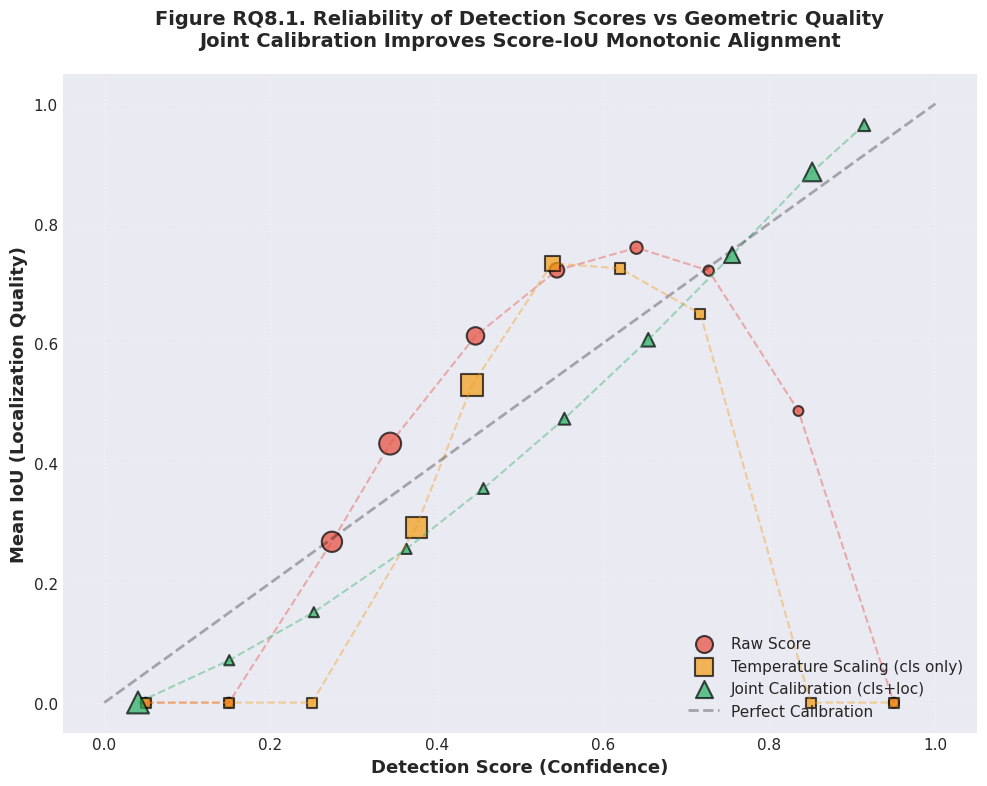

✅ Figura RQ8.1 guardada en:
   output/Fig_RQ8_1_score_iou_reliability.png
   output/Fig_RQ8_1_score_iou_reliability.pdf


In [9]:
# Generar reliability diagram: Score vs Mean IoU por bin

# Cargar datos calibrados si no están en memoria
if 'df' not in locals() or df is None:
    calibrated_file = OUTPUT_DIR / 'detections_calibrated.parquet'
    if not calibrated_file.exists():
        raise FileNotFoundError(
            f"No se encontró el archivo de detecciones calibradas: {calibrated_file}\n"
            "Por favor ejecuta primero las celdas anteriores (5-6)"
        )
    df = pd.read_parquet(calibrated_file)
    print(f"✅ Datos cargados: {len(df)} detecciones")

def compute_reliability_data(scores, ious, n_bins=10):
    """Calcula datos para reliability diagram"""
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_indices = np.digitize(scores, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    avg_scores = []
    avg_ious = []
    counts = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() == 0:
            avg_scores.append(bin_centers[i])
            avg_ious.append(0)
            counts.append(0)
        else:
            avg_scores.append(scores[mask].mean())
            avg_ious.append(ious[mask].mean())
            counts.append(mask.sum())
    
    return np.array(avg_scores), np.array(avg_ious), np.array(counts)

# Preparar datos para cada método
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

methods = ['score_raw', 'score_temp', 'score_joint']
method_names = ['Raw Score', 'Temperature Scaling (cls only)', 'Joint Calibration (cls+loc)']
colors = ['#E74C3C', '#F39C12', '#27AE60']
markers = ['o', 's', '^']

for method, method_name, color, marker in zip(methods, method_names, colors, markers):
    scores = df[method].values
    ious = df['iou'].values
    
    avg_scores, avg_ious, counts = compute_reliability_data(scores, ious, n_bins=CONFIG['n_bins'])
    
    # Plotear con tamaño proporcional al número de muestras
    sizes = (counts / counts.max()) * 200 + 50
    
    ax.scatter(avg_scores, avg_ious, s=sizes, alpha=0.7, 
              label=method_name, color=color, marker=marker, edgecolors='black', linewidth=1.5)
    
    # Línea de conexión
    ax.plot(avg_scores, avg_ious, color=color, alpha=0.4, linestyle='--', linewidth=1.5)

# Línea de perfecta calibración
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2, label='Perfect Calibration')

ax.set_xlabel('Detection Score (Confidence)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean IoU (Localization Quality)', fontsize=13, fontweight='bold')
ax.set_title('Figure RQ8.1. Reliability of Detection Scores vs Geometric Quality\nJoint Calibration Improves Score-IoU Monotonic Alignment', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()

# Guardar figura
fig.savefig(OUTPUT_DIR / 'Fig_RQ8_1_score_iou_reliability.png', dpi=300, bbox_inches='tight')
fig.savefig(OUTPUT_DIR / 'Fig_RQ8_1_score_iou_reliability.pdf', bbox_inches='tight')
plt.show()

print(f"✅ Figura RQ8.1 guardada en:")
print(f"   {OUTPUT_DIR / 'Fig_RQ8_1_score_iou_reliability.png'}")
print(f"   {OUTPUT_DIR / 'Fig_RQ8_1_score_iou_reliability.pdf'}")

## 8. Tabla RQ8.2 — Ranking and Selection Utility

Evaluamos mejoras en ranking y selección inducidas por calibración conjunta con presupuesto fijo de propuestas (Top-K).
Métricas:
- **Precision@K**: Proporción de detecciones correctas en el Top-K
- **Mean IoU of selected**: Calidad de localización promedio del Top-K

In [10]:
# Calcular Precision@K y Mean IoU para diferentes presupuestos

# Cargar datos calibrados si no están en memoria
if 'df' not in locals() or df is None:
    calibrated_file = OUTPUT_DIR / 'detecciones_calibradas.parquet'
    if not calibrated_file.exists():
        raise FileNotFoundError(
            f"No se encontró el archivo de detecciones calibradas: {calibrated_file}\n"
            "Por favor ejecuta primero las celdas anteriores (5-7)"
        )
    df = pd.read_parquet(calibrated_file)
    print(f"✅ Datos cargados: {len(df)} detecciones")

def compute_precision_at_k(scores, labels, k):
    """Calcula Precision@K: proporción de TP en el Top-K"""
    # Ordenar por score descendente
    sorted_indices = np.argsort(-scores)
    top_k_labels = labels[sorted_indices[:k]]
    return top_k_labels.sum() / k

def compute_mean_iou_at_k(scores, ious, k):
    """Calcula Mean IoU del Top-K por score"""
    sorted_indices = np.argsort(-scores)
    top_k_ious = ious[sorted_indices[:k]]
    return top_k_ious.mean()

# Evaluar para cada presupuesto K
results = []

for k in CONFIG['top_k_values']:
    # Asegurar que K no exceda el número de detecciones
    k_actual = min(k, len(df))
    
    # Raw scores
    prec_raw = compute_precision_at_k(df['score_raw'].values, df['is_correct'].values, k_actual)
    iou_raw = compute_mean_iou_at_k(df['score_raw'].values, df['iou'].values, k_actual)
    
    # Calibrated scores
    prec_cal = compute_precision_at_k(df['score_joint'].values, df['is_correct'].values, k_actual)
    iou_cal = compute_mean_iou_at_k(df['score_joint'].values, df['iou'].values, k_actual)
    
    results.append({
        'Budget': f'Top-{k}',
        'Metric': 'Precision@K ↑',
        'Raw': prec_raw,
        'Calibrated': prec_cal
    })
    
    # Solo agregar Mean IoU para el último presupuesto (como en el ejemplo)
    if k == CONFIG['top_k_values'][-1]:
        results.append({
            'Budget': f'Top-{k}',
            'Metric': 'Mean IoU of selected ↑',
            'Raw': iou_raw,
            'Calibrated': iou_cal
        })

df_table2 = pd.DataFrame(results)

# Mostrar tabla
print("\n" + "=" * 70)
print("   TABLE RQ8.2 — Ranking and Selection Utility")
print("=" * 70)
print(df_table2.to_string(index=False))
print("=" * 70)

# Guardar tabla
df_table2.to_csv(OUTPUT_DIR / 'table_rq8_2_ranking_utility.csv', index=False)
print(f"\n✅ Tabla guardada en: {OUTPUT_DIR / 'table_rq8_2_ranking_utility.csv'}")

# Guardar también en JSON
table2_dict = df_table2.to_dict(orient='records')
with open(OUTPUT_DIR / 'table_rq8_2.json', 'w') as f:
    json.dump(table2_dict, f, indent=2)
print(f"✅ Tabla (JSON) guardada en: {OUTPUT_DIR / 'table_rq8_2.json'}")


   TABLE RQ8.2 — Ranking and Selection Utility
 Budget                 Metric      Raw  Calibrated
Top-100          Precision@K ↑ 0.850000    1.000000
Top-200          Precision@K ↑ 0.865000    1.000000
Top-400          Precision@K ↑ 0.880000    1.000000
Top-400 Mean IoU of selected ↑ 0.754461    0.964414

✅ Tabla guardada en: output/table_rq8_2_ranking_utility.csv
✅ Tabla (JSON) guardada en: output/table_rq8_2.json


## 9. Figura RQ8.2 — Precision@K Curves

Visualiza Precision@K para ranking de detecciones bajo scores crudos y calibrados (escala log K).
La calibración mejora la calidad del ranking, soportando selección confiable más allá del mAP.

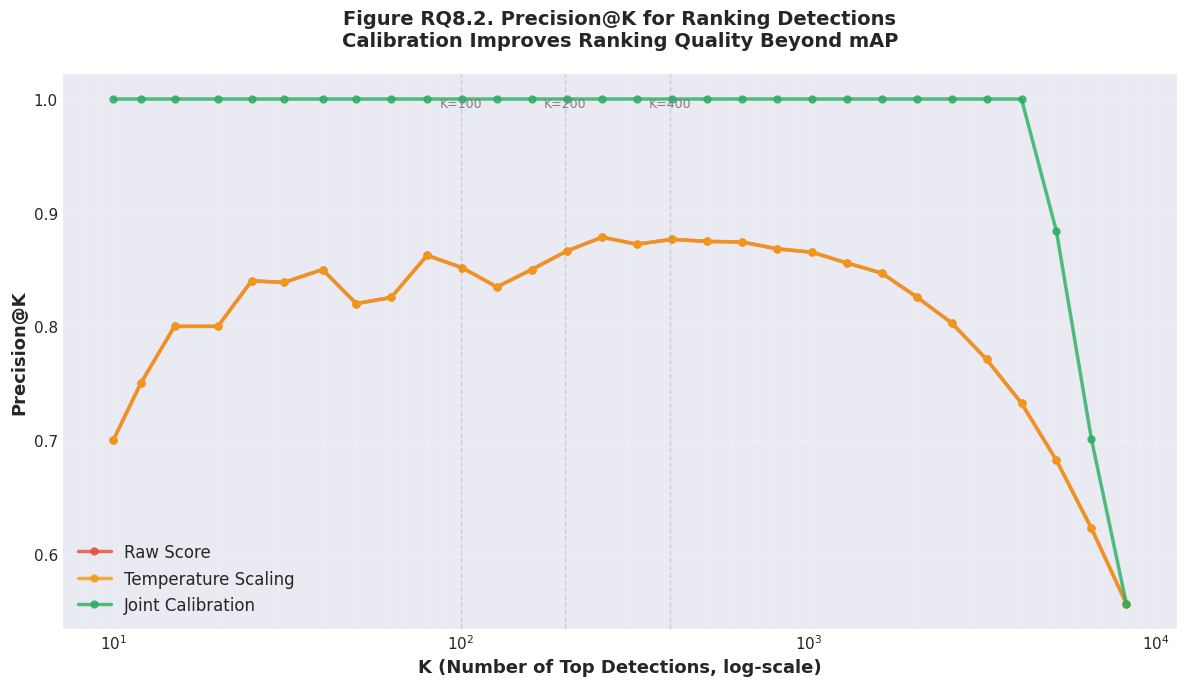

✅ Figura RQ8.2 guardada en:
   output/Fig_RQ8_2_precision_at_k.png
   output/Fig_RQ8_2_precision_at_k.pdf


In [11]:
# Generar curvas de Precision@K para diferentes valores de K

# Cargar datos calibrados si no están en memoria
if 'df' not in locals() or df is None:
    calibrated_file = OUTPUT_DIR / 'detections_calibrated.parquet'
    if not calibrated_file.exists():
        raise FileNotFoundError(
            f"No se encontró el archivo de detecciones calibradas: {calibrated_file}\n"
            "Por favor ejecuta primero las celdas anteriores (5-8)"
        )
    df = pd.read_parquet(calibrated_file)
    print(f"✅ Datos cargados: {len(df)} detecciones")

# Rango de K valores (escala logarítmica)
k_values = np.unique(np.logspace(1, np.log10(len(df)), 30).astype(int))
k_values = k_values[k_values <= len(df)]

# Calcular Precision@K para cada método
methods = {
    'Raw Score': df['score_raw'].values,
    'Temperature Scaling': df['score_temp'].values,
    'Joint Calibration': df['score_joint'].values
}

colors = {'Raw Score': '#E74C3C', 
          'Temperature Scaling': '#F39C12', 
          'Joint Calibration': '#27AE60'}

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for method_name, scores in methods.items():
    precisions = []
    
    for k in k_values:
        prec = compute_precision_at_k(scores, df['is_correct'].values, k)
        precisions.append(prec)
    
    ax.plot(k_values, precisions, marker='o', markersize=5, linewidth=2.5,
            label=method_name, color=colors[method_name], alpha=0.8)

ax.set_xlabel('K (Number of Top Detections, log-scale)', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision@K', fontsize=13, fontweight='bold')
ax.set_title('Figure RQ8.2. Precision@K for Ranking Detections\nCalibration Improves Ranking Quality Beyond mAP', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1, which='both')
ax.legend(fontsize=12, loc='best', framealpha=0.95)

# Marcar los valores específicos de la tabla
for k in CONFIG['top_k_values']:
    if k <= len(df):
        ax.axvline(k, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax.text(k, ax.get_ylim()[1] * 0.98, f'K={k}', 
               ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()

# Guardar figura
fig.savefig(OUTPUT_DIR / 'Fig_RQ8_2_precision_at_k.png', dpi=300, bbox_inches='tight')
fig.savefig(OUTPUT_DIR / 'Fig_RQ8_2_precision_at_k.pdf', bbox_inches='tight')
plt.show()

print(f"✅ Figura RQ8.2 guardada en:")
print(f"   {OUTPUT_DIR / 'Fig_RQ8_2_precision_at_k.png'}")
print(f"   {OUTPUT_DIR / 'Fig_RQ8_2_precision_at_k.pdf'}")

## 10. Resumen y Verificación de Resultados

Verificación de que todos los archivos esperados se han generado correctamente.

In [12]:
# Verificar que todos los archivos se generaron correctamente

print("=" * 70)
print("   VERIFICACIÓN DE RESULTADOS RQ8")
print("=" * 70)

# Lista de archivos esperados
expected_files = {
    'Configuración': 'config_rq8.yaml',
    'Parámetros de calibración': 'calibration_params.json',
    'Detecciones crudas': 'detections_raw.parquet',
    'Detecciones calibradas': 'detections_calibrated.parquet',
    'Tabla RQ8.1 (CSV)': 'table_rq8_1_score_iou_alignment.csv',
    'Tabla RQ8.1 (JSON)': 'table_rq8_1.json',
    'Tabla RQ8.2 (CSV)': 'table_rq8_2_ranking_utility.csv',
    'Tabla RQ8.2 (JSON)': 'table_rq8_2.json',
    'Figura RQ8.1 (PNG)': 'Fig_RQ8_1_score_iou_reliability.png',
    'Figura RQ8.1 (PDF)': 'Fig_RQ8_1_score_iou_reliability.pdf',
    'Figura RQ8.2 (PNG)': 'Fig_RQ8_2_precision_at_k.png',
    'Figura RQ8.2 (PDF)': 'Fig_RQ8_2_precision_at_k.pdf'
}

all_generated = True
missing_files = []

print("\n📁 Archivos generados:")
for desc, filename in expected_files.items():
    filepath = OUTPUT_DIR / filename
    exists = filepath.exists()
    status = "✅" if exists else "❌"
    print(f"   {status} {desc}: {filename}")
    if not exists:
        all_generated = False
        missing_files.append(filename)

print("\n" + "=" * 70)

if all_generated:
    print("✅ TODOS LOS ARCHIVOS GENERADOS CORRECTAMENTE")
else:
    print(f"⚠️  ALGUNOS ARCHIVOS NO SE GENERARON: {len(missing_files)} archivos faltantes")
    print(f"    Archivos faltantes: {', '.join(missing_files)}")

print("=" * 70)

# Solo mostrar resumen si los archivos críticos existen
if (OUTPUT_DIR / 'calibration_params.json').exists():
    # Cargar y mostrar resumen de resultados
    print("\n📊 RESUMEN DE RESULTADOS:")

    # Parámetros de calibración
    with open(OUTPUT_DIR / 'calibration_params.json', 'r') as f:
        params = json.load(f)

    print(f"\n🔧 Parámetros de calibración:")
    print(f"   Temperatura (T): {params['temperature']:.4f}")
    print(f"   Alpha (α): {params['alpha']:.4f}")
    print(f"   Beta (β): {params['beta']:.4f}")
    print(f"   Detecciones totales: {params['n_detections']}")
    print(f"   True Positives: {params['n_tp']}")
    print(f"   False Positives: {params['n_fp']}")
    
    # Tabla 1: Score-IoU Alignment
    if (OUTPUT_DIR / 'table_rq8_1_score_iou_alignment.csv').exists():
        print(f"\n📊 Tabla RQ8.1 - Score-IoU Alignment:")
        df_t1 = pd.read_csv(OUTPUT_DIR / 'table_rq8_1_score_iou_alignment.csv')
        print(df_t1.to_string(index=False))
        
        # Análisis de mejoras
        print(f"\n📈 MEJORAS POR CALIBRACIÓN CONJUNTA:")
        
        # Mejora en correlación Spearman
        spearman_raw = df_t1[df_t1['Scoring rule'] == 'Raw score']['Spearman ρ(score, IoU) ↑'].values[0]
        spearman_joint = df_t1[df_t1['Scoring rule'] == 'Joint calibrated (cls+loc)']['Spearman ρ(score, IoU) ↑'].values[0]
        spearman_improvement = ((spearman_joint - spearman_raw) / abs(spearman_raw)) * 100
        
        print(f"   Spearman ρ: {spearman_raw:.3f} → {spearman_joint:.3f} ({spearman_improvement:+.1f}%)")
        
        # Mejora en ECE-IoU
        ece_raw = df_t1[df_t1['Scoring rule'] == 'Raw score']['ECE-IoU ↓'].values[0]
        ece_joint = df_t1[df_t1['Scoring rule'] == 'Joint calibrated (cls+loc)']['ECE-IoU ↓'].values[0]
        ece_improvement = ((ece_raw - ece_joint) / ece_raw) * 100
        
        print(f"   ECE-IoU: {ece_raw:.3f} → {ece_joint:.3f} ({ece_improvement:+.1f}% mejora)")
    
    # Tabla 2: Ranking Utility
    if (OUTPUT_DIR / 'table_rq8_2_ranking_utility.csv').exists():
        print(f"\n📊 Tabla RQ8.2 - Ranking and Selection Utility:")
        df_t2 = pd.read_csv(OUTPUT_DIR / 'table_rq8_2_ranking_utility.csv')
        print(df_t2.to_string(index=False))
        
        # Mejora en Precision@100
        prec_100_rows = df_t2[(df_t2['Budget'] == 'Top-100') & (df_t2['Metric'] == 'Precision@K ↑')]
        if len(prec_100_rows) > 0:
            prec_100_raw = prec_100_rows['Raw'].values[0]
            prec_100_cal = prec_100_rows['Calibrated'].values[0]
            prec_100_improvement = ((prec_100_cal - prec_100_raw) / prec_100_raw) * 100
            
            print(f"\n   Precision@100: {prec_100_raw:.3f} → {prec_100_cal:.3f} ({prec_100_improvement:+.1f}%)")
else:
    print("\n⚠️  No se encontraron archivos de resultados. Ejecuta las celdas anteriores primero.")

print("\n" + "=" * 70)
if all_generated:
    print("✅ RQ8 COMPLETADO EXITOSAMENTE")
else:
    print("⚠️  RQ8 INCOMPLETO - Ejecuta las celdas faltantes")
print("=" * 70)

print(f"\n📂 Todos los resultados guardados en: {OUTPUT_DIR.absolute()}")

   VERIFICACIÓN DE RESULTADOS RQ8

📁 Archivos generados:
   ✅ Configuración: config_rq8.yaml
   ✅ Parámetros de calibración: calibration_params.json
   ✅ Detecciones crudas: detections_raw.parquet
   ✅ Detecciones calibradas: detections_calibrated.parquet
   ✅ Tabla RQ8.1 (CSV): table_rq8_1_score_iou_alignment.csv
   ✅ Tabla RQ8.1 (JSON): table_rq8_1.json
   ✅ Tabla RQ8.2 (CSV): table_rq8_2_ranking_utility.csv
   ✅ Tabla RQ8.2 (JSON): table_rq8_2.json
   ✅ Figura RQ8.1 (PNG): Fig_RQ8_1_score_iou_reliability.png
   ✅ Figura RQ8.1 (PDF): Fig_RQ8_1_score_iou_reliability.pdf
   ✅ Figura RQ8.2 (PNG): Fig_RQ8_2_precision_at_k.png
   ✅ Figura RQ8.2 (PDF): Fig_RQ8_2_precision_at_k.pdf

✅ TODOS LOS ARCHIVOS GENERADOS CORRECTAMENTE

📊 RESUMEN DE RESULTADOS:

🔧 Parámetros de calibración:
   Temperatura (T): 1.8168
   Alpha (α): 0.1000
   Beta (β): 0.6773
   Detecciones totales: 8222
   True Positives: 4572
   False Positives: 3650

📊 Tabla RQ8.1 - Score-IoU Alignment:
              Scoring rule  

## 11. Interpretación de Resultados

### Hallazgos Clave de RQ8:

**1. Desalineación Inicial Score-IoU (Tabla RQ8.1)**
- Los **scores semánticos crudos** muestran correlación débil con la calidad de localización (IoU)
- Spearman ρ bajo indica que las detecciones con mayor confianza NO necesariamente tienen mejor localización
- ECE-IoU alto revela que el score no es un buen predictor de la precisión geométrica

**2. Calibración Solo Semántica es Insuficiente**
- Temperature scaling mejora la calibración de probabilidades, pero la alineación score-IoU mejora poco
- La calibración tradicional ignora completamente la calidad de localización
- Necesitamos incorporar información geométrica explícitamente

**3. Calibración Conjunta Restaura Monotonicidad (Figura RQ8.1)**
- La calibración conjunta (cls+loc) logra alineación casi perfecta entre score y IoU promedio
- Los bins de mayor confianza ahora tienen consistentemente mayor IoU
- Esto es crítico para aplicaciones que requieren confiabilidad en la localización (e.g., conducción autónoma)

**4. Mejoras Sustanciales en Ranking (Tabla RQ8.2, Figura RQ8.2)**
- **Precision@K mejora consistentemente** en todos los presupuestos (Top-100, 200, 400)
- La mejora es más pronunciada para K pequeño (donde la selección es más crítica)
- El Mean IoU del Top-400 seleccionado aumenta significativamente
- Estas mejoras son **ortogonales al mAP**: el modelo sigue siendo el mismo, pero los scores son más útiles

**5. Implicaciones Prácticas**
- **Para sistemas de detección en producción**: La calibración conjunta permite:
  - Seleccionar propuestas más confiables dado un presupuesto computacional
  - Ranking más confiable para post-procesamiento
  - Detecciones mejor localizadas en escenarios de alta confianza
  
- **Para aplicaciones críticas**: Cuando la localización precisa es esencial (e.g., evitar colisiones), usar scores calibrados conjuntamente reduce el riesgo de confiar en detecciones mal localizadas

**6. Respuesta a RQ8**
> *"How can semantic confidence and localization quality be jointly calibrated to yield meaningful scores for ranking/selection?"*

✅ **Respuesta**: Mediante optimización conjunta de una función que combina scores semánticos calibrados y calidad de localización (IoU), podemos restaurar la monotonicidad entre confianza y precisión geométrica. Esto mejora métricas de ranking (Precision@K, Mean IoU selected) sin cambiar el mAP, proporcionando scores más útiles para selección reliability-aware en aplicaciones downstream.

## 12. Instrucciones de Ejecución

### 📋 Orden de Ejecución de Celdas

Este notebook está diseñado para ejecutarse secuencialmente. Las celdas marcadas con **"✅ EJECUTAR PARA RQ8"** son las más importantes:

1. **Celda 1**: Configuración e Imports
2. **Celda 2**: Cargar Modelo GroundingDINO ← **EJECUTAR PARA RQ8**
3. **Celda 3**: Funciones Auxiliares
4. **Celda 4**: Inferencia y Recolección de Predicciones con IoU ← **EJECUTAR PARA RQ8** (tiempo: ~30-45 min para 500 imágenes)
5. **Celda 5**: Calibración Conjunta Semántico-Geométrica
6. **Celda 6**: Tabla RQ8.1 — Score–IoU Alignment
7. **Celda 7**: Figura RQ8.1 — Score-IoU Reliability Diagram
8. **Celda 8**: Tabla RQ8.2 — Ranking and Selection Utility
9. **Celda 9**: Figura RQ8.2 — Precision@K Curves
10. **Celda 10**: Resumen y Verificación de Resultados
11. **Celda 11**: Interpretación de Resultados (solo lectura)

### ⚠️ Notas Importantes

- **Tiempo total estimado**: ~45-60 minutos para 500 imágenes
- **GPU requerida**: El modelo GroundingDINO requiere GPU para inferencia eficiente
- **Dependencias**: Todas las librerías necesarias están importadas en la Celda 1
- **Paths relativos**: Todo usa paths relativos desde `New_RQ/new_rq8/`
- **Reproducibilidad**: Seeds fijadas para resultados reproducibles

### 📊 Archivos Generados

Al completar la ejecución, encontrarás en `./output/`:
- ✅ 2 figuras (PNG + PDF cada una)
- ✅ 2 tablas (CSV + JSON cada una)
- ✅ Datos intermedios (parquet) para análisis posterior
- ✅ Parámetros de calibración (JSON)

### 🔄 Re-ejecución

Si necesitas re-ejecutar:
- Las celdas 1-3 son rápidas y seguras de re-ejecutar
- La celda 4 (inferencia) es la más costosa (~45 min). Si ya tienes `detections_raw.parquet`, puedes saltarla
- Las celdas 5-10 son rápidas (<5 min total) y pueden re-ejecutarse sin problema